<a href="https://colab.research.google.com/github/ryanzhangofficial/protein-structure-ai/blob/main/protein_structure_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np, zipfile
zipfile.ZipFile("CB513.npy.zip").extractall()
arr = np.load("CB513.npy")
arr = arr.reshape(-1, 700, 57)
X = arr[:, :, :22]
y = arr[:, :, 35:38]
mask = (X.sum(axis=2) > 0).astype(np.float32)

<ipython-input-2-bf35638e352d>:3: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  arr = np.load("CB513.npy")


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    X, y, mask, test_size=0.1, random_state=42
)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
inputs = layers.Input(shape=(700, 22))
x = layers.Conv1D(64, 7, padding="same", activation="relu")(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Conv1D(64, 7, padding="same", activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.TimeDistributed(layers.Dense(3, activation="softmax"))(x)
model = Model(inputs, outputs)

In [5]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train,
    sample_weight=m_train,
    validation_data=(X_val, y_val, m_val),
    epochs=15,
    batch_size=32
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 416s 20s/step - accuracy: 0.5808 - loss: 0.1974 - val_accuracy: 0.9051 - val_loss: 0.1972
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.7993 - loss: 0.1888 - val_accuracy: 0.9066 - val_loss: 0.1899
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8179 - loss: 0.1838 - val_accuracy: 0.9126 - val_loss: 0.1878
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8753 - loss: 0.1859 - val_accuracy: 0.9115 - val_loss: 0.1871
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8903 - loss: 0.1744 - val_accuracy: 0.9128 - val_loss: 0.1867
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8848 - loss: 0.1863 - val_accuracy: 0.9127 - val_loss: 0.1862
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8882 - loss: 0.1821 - val_accuracy: 0.9141 - val_loss: 0.1858
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9045 - loss: 0.1848 - val_accuracy: 0.9142 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 105s 51s/step


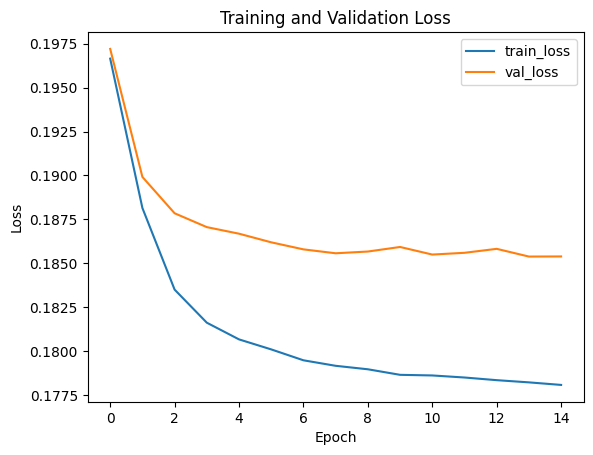

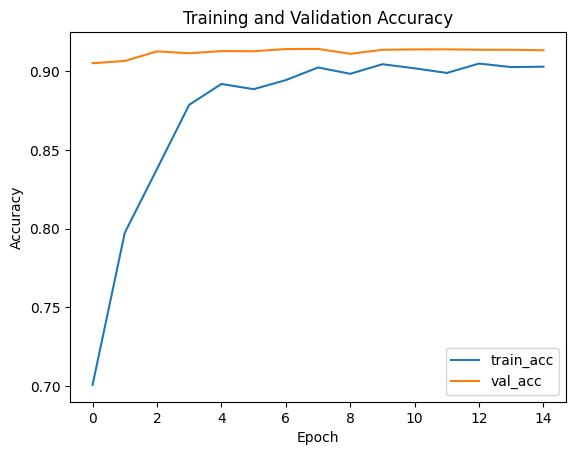

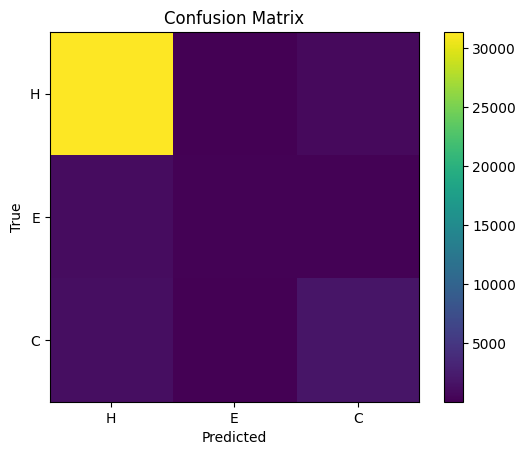

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1) Plot training & validation loss
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# 2) Plot training & validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# 3) Compute & plot confusion matrix on masked validation positions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=-1)
y_true = np.argmax(y_val, axis=-1)

mask_flat = m_val.flatten() == 1
y_pred_flat = y_pred.flatten()[mask_flat]
y_true_flat = y_true.flatten()[mask_flat]

cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1, 2], ["H", "E", "C"])
plt.yticks([0, 1, 2], ["H", "E", "C"])

plt.show()

In [7]:
model.save("protein_ss_model.h5")

In [9]:
import numpy as np

sample_input = X_val[0:1]
print(f"Sample Input: {sample_input}")
pred_probs = model.predict(sample_input)
pred_labels = np.argmax(pred_probs, axis=-1)

print("Predicted classes for positions 1–10 (0=H, 1=E, 2=C):")
print(pred_labels[0, :10])

Sample Input: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step
Predicted classes for positions 1–10 (0=H, 1=E, 2=C):
[0 0 2 0 0 0 2 0 2 0]
